## Limitations ##

Before attempting the problem, I want to list down the limitations of this problem and how they affect the analysis:
1. The fields in the data do not have any description. All the naked eye can see is the presence of 7 continuous variables and 2 categorical variables. With only this information about the data and no well-defined problem statement, it is not possible to discard any variable using the doamin knowledge. Only some statistical feature selection methods can be implemented at later stage to optimize our model.

2. There are only 500 observations in our training data, and that might mean that our model will not have enough data to 'learn'.

3. Also, since there is no data description given, I have built by model with accuracy as my sole focus.

## Data Exploration ##

In [15]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.feature_selection import RFE
import seaborn as sns
import statsmodels.api as sm

In [2]:
df_intern = pd.read_csv('intern_data.csv')

In [3]:
df_intern.head()

,Unnamed: 0,a,b,c,d,e,f,g,h,y
0,7,0.951786,0.669570,green,0.170130,0.623469,0.925886,0.812685,white,3.707514
1,43,0.510447,0.922627,red,0.087899,0.025415,0.698444,0.658545,white,2.689243
2,47,0.294838,0.351081,yellow,0.710892,0.699661,0.545722,0.836863,black,2.886508
3,53,0.798645,0.572042,green,0.026137,0.609730,0.488668,0.342675,black,2.478168
4,54,0.689666,0.395323,red,0.172448,0.736433,0.708408,0.695521,white,3.182666


The question asks us to build a model using on a-h variables, so we can get rid of the unnamed column at the start.

In [4]:
del df_intern['Unnamed: 0']

Apart from the removal of this column, everything else in the data looks good to me. Naturally, not all of these features will be used for actual regression, and thus we will have to perform feature selection to obtain the best predictors. However, apart from this, everything else about the data looks clean, so I am assuming that the goal for this exercise is not to perform data cleaning (which is the task in Data Science process that takes the maximum amount of time).

Let us have a look at the data types for all the fields.

In [5]:
df_intern.dtypes

a    float64
b    float64
c     object
d    float64
e    float64
f    float64
g    float64
h     object
y    float64
dtype: object

Now let us look at the size of our dataset.

In [6]:
df_intern.shape

(500, 9)

Finally, let us run some descriptive analysis for our data.

In [7]:
df_intern.describe()

,a,b,d,e,f,g,y
count,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000
mean,0.497413,0.505397,0.501722,0.501899,0.526562,0.508442,2.682803
std,0.292947,0.292450,0.284623,0.272019,0.292175,0.284332,0.592533
min,0.002801,0.000369,0.000592,0.002387,0.001327,0.005644,0.981376
25%,0.253897,0.256446,0.252244,0.270069,0.262523,0.263525,2.300795
50%,0.510420,0.514069,0.496800,0.515185,0.506412,0.526403,2.726900
75%,0.760192,0.766578,0.735650,0.732240,0.790898,0.742125,3.155562
max,0.999690,0.997025,0.998282,0.998994,0.999271,0.998156,3.980509


In [8]:
print(df_intern['c'].value_counts())
print(df_intern['h'].value_counts())

yellow    134
green     124
blue      123
red       119
Name: c, dtype: int64
white    392
black    108
Name: h, dtype: int64


It is clear that the distribution of the 'c' variable classes is pretty event. However, in case of the 'h' variable, the counts are highly biased towards the white.

## Visualization of the correlation between the variables and their distributions ##

Before we start building a linear regression model, there are several key assumptions that we need to take care of:
1. Variables are normally distributed:
Non-normally distributed variables (highly skewed variables or variables with substantial outliers) can distort relationships and significance tests.

2. Linear relationship between the predictor and the response:
Standard multiple regression can only accurately estimate the relationship between dependent and independent variables if the relationships are linear in nature. If the relationship between
each of the predictors and the response is not linear, the results of the regression analysis will under-estimate the true relationship.

3. Variables are measured without error:
Effect sizes of other variables can be over-estimated if the covariate is not reliably measured, as the full effect of the covariate(s) would not be removed.

4. Absence of homoscedasticity:
Homoscedasticity means that the variance of errors is the same across all levels of the IV. It can lead to serious distortion of findings and seriously weaken the analysis.

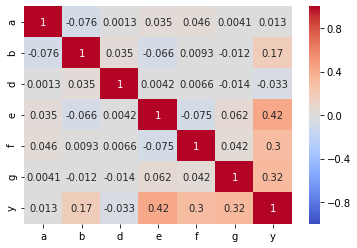

In [9]:
#Correlation heatmap
sns.heatmap(df_intern.corr(), annot = True, vmin=-1, vmax=1, center= 0, cmap= 'coolwarm')

The scatter plot above shows that there is a decent amount of correlation between the predictors (a-h) and the response variable (y), with the clear exception of variable a and d with y.

One good thing is that there is no linear relationship of the predictors with each other. Presence of such a linear relationship will give incorrect results during regression.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000025F13AB5208>,
      dtype=object)

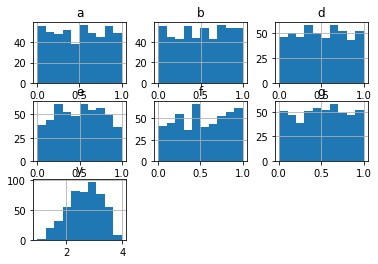

In [10]:
df_intern.hist()

The variables should be noramally distributed. We see that our vairables a-h are not really normally distributed, so this assumption of linear regression is disobeyed.

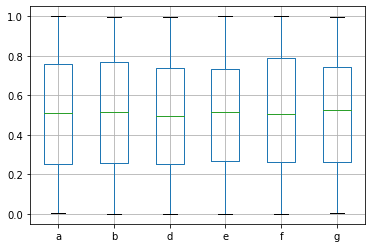

In [11]:
#Boxplots

df_intern.boxplot(column=list('abdefg'))

The boxplots show that the means of all the distributions are fairly similar. In fact, even the 1st and 3rd quartiles of the distributions are very close to each other.

#### Separating out test data from our main data before feature selection ####

In [12]:
X = pd.get_dummies(df_intern).drop(['y'], axis=1)
y = df_intern['y']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

## Feature Selection - Choosing the best predictors ##

Why do we even need feature selection?
1. It makes the machine learning model faster.
2. It improves the accuracy of a model.
3. It reduces the complexity of a model and makes it more interpretable.
4. It reduces Overfitting in our model.

There are three broad types of feature selection methods that I know:
1. Filter based methods
2. Wrapper methods
3. Embedded methods

The feature selection methods we will use here all come under what is called a 'Wrapper Method'. Wrapper feature selection methods create many models with different subsets of input features and select those features that result in the best performing model according to a performance metric. This is an iterative and computationally expensive process but since we have very less number of features, we can use this method.

The wrapper methods we will use here are Backward selection and RFE.

In backward feature selection method, we feed all the possible features to the model, check the performance of the model and then iteratively remove the worst performing features one by one till the overall performance of the model comes in acceptable range. The performance metric used here to evaluate feature performance is pvalue.

In [13]:
cols = list(X_train.columns)
pmax = 1
while (len(cols)>0):
    p= []
    X_1 = X_train[cols]
    X_1 = sm.add_constant(X_1)
    model = sm.OLS(y_train,X_1).fit()
    p = pd.Series(model.pvalues.values[1:],index = cols)      
    pmax = max(p)
    feature_with_p_max = p.idxmax()
    if(pmax>0.05):
        cols.remove(feature_with_p_max)
    else:
        break

selected_features_BE = cols
print(selected_features_BE)

['b', 'e', 'f', 'g', 'c_blue', 'c_green', 'c_red', 'c_yellow', 'h_white']


C:\Users\iGuest\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


The Recursive Feature Elimination (RFE) method works by recursively removing attributes and building a model on those attributes that remain. It uses accuracy metric to rank the feature according to their importance.

Instead of taking the number of features randomly, we can find the optimum number of features by using loop starting with 1 feature and going up to 12 features and then choose the one for which the accuracy is highest.

In [16]:
#no of features
nof_list=np.arange(1,12)            
high_score=0
#Variable to store the optimum features
nof=0           
score_list =[]
for n in range(len(nof_list)):
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3, random_state = 0)
    model = LinearRegression()
    rfe = RFE(model,nof_list[n])
    X_train_rfe = rfe.fit_transform(X_train,y_train)
    X_test_rfe = rfe.transform(X_test)
    model.fit(X_train_rfe,y_train)
    score = model.score(X_test_rfe,y_test)
    score_list.append(score)
    if(score>high_score):
        high_score = score
        nof = nof_list[n]

print("Optimum number of features: %d" %nof)
print("Score with %d features: %f" % (nof, high_score))

Optimum number of features: 9
Score with 9 features: 0.972735


Now that we have an optimum number of features, we can implement RFE to obtain these 9 best features.

In [17]:
cols = list(X.columns)
model = LinearRegression()

#Initializing RFE model
rfe = RFE(model, 9)             

#Transforming data using RFE
X_rfe = rfe.fit_transform(X,y)  

#Fitting the data to model
model.fit(X_rfe,y)              
temp = pd.Series(rfe.support_,index = cols)
selected_features_rfe = temp[temp==True].index

print(selected_features_rfe)

Index(['b', 'e', 'f', 'g', 'c_blue', 'c_green', 'c_yellow', 'h_black',
       'h_white'],
      dtype='object')


## Building Regression Models ##

By now we are already clear that since we have a label in our data, it is a supervised learning problem. Also, since we are predicting a continuous variable, it is a regression problem.

So with this information, we now have to decide which algorithm to finally go with. Now idedally, there are several things I like to check before selecting any model:
1. Checking if the model aligns to the business goals
2. The amount of pre-processing before building the model
3. How interpretable the model is
4. How long does it take to build a model, and how long does the model take to make predictions
5. Checking the accuracy of the model
6. The scalability of the model

Now for our current problem, we do not have any business goals defined, so we shall skip the first check. Next, we see that the data given to us was already clean, so the data cleaning section of pre-processing isn't needed either. The only pre-processing that we did was feature reduction. This ensures that the pre-processing for our current data will not take a lot of time. Without any data description, the interpretability of the model also becomes difficult to test. Easiest and most basic way to explain our model will be that we are trying to fit a parametric function on our data to predict a continous response variable.

Regarding the speed of the model, we first need to check the model complexity. The model will use only 9 features, and the amount of training data will also not be over 500 (even if we decide to use all our available data for training). Additionally, we also haven't used any complex feature engineering methods like principal component analysis on our data for dimensionality reduction. Accuracy is something we will be testing in the code below. The scalability of the model is something that is out of scope for our current problem.

For the sake of simplicity, I will only compare the following regression based algorithms:
1. Multiple Linear Regression
2. Random Forest
3. K-Nearest Neighbours

Since there is not much multicolinearity or high dimensionality in our data, we do not unnecessarily use any regression regularization methods like Ridge, Lasso or ElasticNet.
Similarly, since we have only one response variable, multivariate regression is also out of picture.

#### Multiple Linear Regression ####

In [18]:
lm_rfe = sm.OLS(endog = y_train, exog = X_train[selected_features_rfe]).fit() 
lm_rfe.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.973
Model:                            OLS   Adj. R-squared:                  0.972
Method:                 Least Squares   F-statistic:                     1511.
Date:                Sun, 02 Feb 2020   Prob (F-statistic):          4.44e-261
Time:                        21:55:59   Log-Likelihood:                 319.56
No. Observations:                 350   AIC:                            -621.1
Df Residuals:                     341   BIC:                            -586.4
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
b              0.3890      0.018     21.803      0.000       0.354       0.424
e              0.9603      0.020     48.701      0.000       0.922       0.999
f              0.6770      0.019     36.451      0.000       0.640       0.714
g              0.6056      0.018     32.964      0.000       0.569       0.642
c_blue        -0.5786      0.015    -39.057      0.000      -0.608      -0.549
c_green        0.3157      0.015     20.971      0.000       0.286       0.345
c_yellow       0.3092      0.015     20.668      0.000       0.280       0.339
h_black        0.8225      0.023     35.584      0.000       0.777       0.868
h_white        1.4569      0.021     68.150      0.000       1.415       1.499
==============================================================================
Omnibus:                        3.707   Durbin-Watson:                   1.995
Prob(Omnibus):                  0.157   Jarque-Bera (JB):                3.440
Skew:                          -0.203   Prob(JB):                        0.179
Kurtosis:                       3.267   Cond. No.                         9.34
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [19]:
#Training Error

y_train_pred_rfe = lm_rfe.predict(X_train[selected_features_rfe])

np.sqrt(metrics.mean_squared_error(y_train, y_train_pred_rfe))

0.09710395065164512

In [20]:
y_pred = lm_rfe.predict(X_test[selected_features_rfe])

#Calculate RMSE
np.sqrt(metrics.mean_squared_error(y_test, y_pred))

0.09791147832445794

The Rsquared value in itself is not of any use. We can use it only if we are comparing two models. Let us compare this model which is built using features from RFE to a new model built using features from backward selection.

In [21]:
lm_be = sm.OLS(endog = y_train, exog = X_train[selected_features_BE]).fit() 
lm_be.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.973
Model:                            OLS   Adj. R-squared:                  0.972
Method:                 Least Squares   F-statistic:                     1511.
Date:                Sun, 02 Feb 2020   Prob (F-statistic):          4.44e-261
Time:                        21:56:02   Log-Likelihood:                 319.56
No. Observations:                 350   AIC:                            -621.1
Df Residuals:                     341   BIC:                            -586.4
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
b              0.3890      0.018     21.803      0.000       0.354       0.424
e              0.9603      0.020     48.701      0.000       0.922       0.999
f              0.6770      0.019     36.451      0.000       0.640       0.714
g              0.6056      0.018     32.964      0.000       0.569       0.642
c_blue         0.2439      0.024     10.056      0.000       0.196       0.292
c_green        1.1383      0.024     47.663      0.000       1.091       1.185
c_red          0.8225      0.023     35.584      0.000       0.777       0.868
c_yellow       1.1318      0.023     48.201      0.000       1.086       1.178
h_white        0.6344      0.013     48.426      0.000       0.609       0.660
==============================================================================
Omnibus:                        3.707   Durbin-Watson:                   1.995
Prob(Omnibus):                  0.157   Jarque-Bera (JB):                3.440
Skew:                          -0.203   Prob(JB):                        0.179
Kurtosis:                       3.267   Cond. No.                         12.6
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [22]:
#Training Error

y_train_pred = lm_be.predict(X_train[selected_features_BE])

np.sqrt(metrics.mean_squared_error(y_train, y_train_pred))

0.09710395065164511

In [23]:
#Calculate predictions for this new model
y_pred = lm_be.predict(X_test[selected_features_BE])

np.sqrt(metrics.mean_squared_error(y_test, y_pred))

0.09791147832445787

When it comes to Rsquared, the RFE model is similar to the backward selection model.

But hold on! We have used the Rsquared metric here. Rsquared is highly dependent on the number of features. In fact, if you add a 100 features with noise, there is a high chance that your model Rsquared will even reach 1.

This is where another metric called the Adjusted Rsquared comes into picture. This metric adds a penalty to the model with every new added feature, and this helps us get the true Rsquared value for the model.

For our current scenario, we can confirm that both our models are the same when it comes to either of the two metrics.

#### Random Forest for Regression ####

In [24]:
# Fitting Random Forest Regression to the dataset 
# import the regressor 
from sklearn.ensemble import RandomForestRegressor 
  
# create regressor object 
regressor = RandomForestRegressor(n_estimators = 100, random_state = 42) 
  
# fit the regressor with x and y data 
regressor.fit(X_train, y_train)

y_pred = regressor.predict(X_test)

print(np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

0.21178547570333064


In [25]:
#Variable Importance

importances = list(regressor.feature_importances_)

feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(X_test, importances)]
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

print([{a:b} for a,b in feature_importances])

[{'c_blue': 0.26}, {'e': 0.23}, {'f': 0.11}, {'h_black': 0.11}, {'h_white': 0.11}, {'g': 0.1}, {'b': 0.04}, {'d': 0.02}, {'a': 0.01}, {'c_red': 0.01}, {'c_green': 0.0}, {'c_yellow': 0.0}]


In [26]:
# New random forest with only the two most important variables
rf_most_important = RandomForestRegressor(n_estimators= 1000, random_state=42)

train_important = X_train[['c_blue','e']]
test_important = X_test[['c_blue','e']]

rf_most_important.fit(train_important, y_train)
predictions = rf_most_important.predict(test_important)

print(np.sqrt(metrics.mean_squared_error(y_test, predictions)))

0.5365591106042541


#### K-Nearest Neighbours ###

In [27]:
#Scaling the features
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))

X_train_scaled = scaler.fit_transform(X_train)

X_test_scaled = scaler.fit_transform(X_test)

#Building our kNN model
from sklearn import neighbors
from sklearn.model_selection import GridSearchCV

params = {'n_neighbors':[i for i in range(2,20)]}

knn = neighbors.KNeighborsRegressor()

model = GridSearchCV(knn, params, cv=5)
model.fit(X_train_scaled, y_train)
model.best_params_

{'n_neighbors': 3}

Thus, we see that our best model is built for k=3

In [28]:
pred_knn = model.predict(X_test_scaled)

print(np.sqrt(metrics.mean_squared_error(y_test, pred_knn)))

0.23654065497264903


## Conclusion ##

Looking at only the RMSE for the three types of models, it is clear that the multiple linear regression model with the features selected via RFE gives us the best chance of getting good predictions. Thus, I will be using this model to predict values for the intern_test data provided to me.

In [29]:
df_intern_test = pd.read_csv('intern_test.csv')

df_intern_test.head()

,Unnamed: 0,a,b,c,d,e,f,g,h
0,1,0.213254,0.707218,green,0.206151,0.010148,0.190193,0.497651,black
1,2,0.867987,0.494110,green,0.510344,0.922549,0.649631,0.952224,black
2,3,0.419168,0.579660,yellow,0.832660,0.351641,0.105251,0.277489,white
3,4,0.706512,0.948891,blue,0.546916,0.771624,0.683572,0.311848,white
4,5,0.344634,0.942960,yellow,0.570995,0.315698,0.651284,0.677366,white


In [30]:
X_test_final = pd.get_dummies(df_intern_test)

#Calculate predictions for this new model
y_pred_test_rfe = lm_rfe.predict(X_test_final[selected_features_rfe])

In [31]:
results = pd.DataFrame({'i':[n for n in range(df_intern_test.shape[0])], 'y':y_pred_test_rfe.to_list()})

results.head()

,i,y
0,0,1.853246
1,1,3.232880
2,2,2.568651
3,3,2.640109
4,4,3.287286


In [32]:
results.to_csv('intern_predicted.csv', index=False)

## References ##

Throughout this analysis, I have used several sources for revising concepts. I have been bookmarking these sources over the last few years, and I take opportunities like these to revise them. I've added them below so that they get the credit they deserve:
1. Feature Selection https://towardsdatascience.com/feature-selection-with-pandas-e3690ad8504b
2. Assumptions of Linear Regression https://scholarworks.umass.edu/cgi/viewcontent.cgi?article=1111&context=pare